In [1]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [2]:
def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    size = int(len(images) * split)
    print(len(images), size)

    train_x, valid_x = train_test_split(images, test_size=size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [3]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data('UNET/our_dataset/256')
train_x, train_y = shuffle(train_x, train_y)

992 198


(256, 256, 3)
(1, 256, 256, 3)


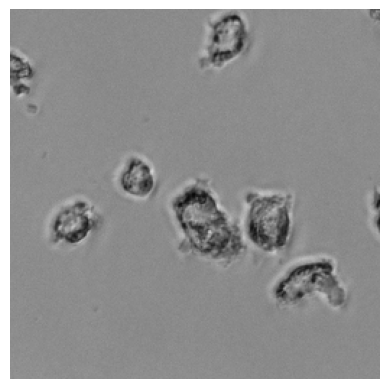

In [11]:

image = cv2.imread(test_x[19])
image_array = np.asarray(image)
print(image_array.shape)
data = np.expand_dims(image_array, axis=0)
print(data.shape)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


1/1 [==============================] - 1s 545ms/step
[[[[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.8778984]]

  [[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.       ]]

  [[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.       ]]

  ...

  [[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.       ]]

  [[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.       ]]

  [[0.       ]
   [0.       ]
   [0.       ]
   ...
   [0.       ]
   [0.       ]
   [0.       ]]]]
(256, 256, 1)


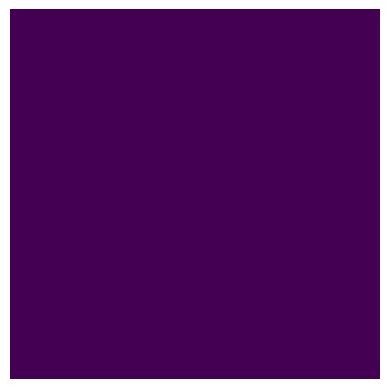

In [13]:
import tensorflow as tf


# model = tf.keras.models.load_model('UNET/saved_models/pruned_model_3.h5')
model = load_model('pruning/pruned_model_3.h5', compile=False)  # Provide the path to your pre-trained model file

predict_test=model.predict(data,verbose=1)


threshold = 0.99

# Apply the threshold
predict_test_binary = (predict_test > threshold).astype(np.uint8)

print(predict_test)

print(predict_test[0].shape)

plt.imshow(predict_test_binary[0])
plt.axis('off')  # Hide axes
plt.show()

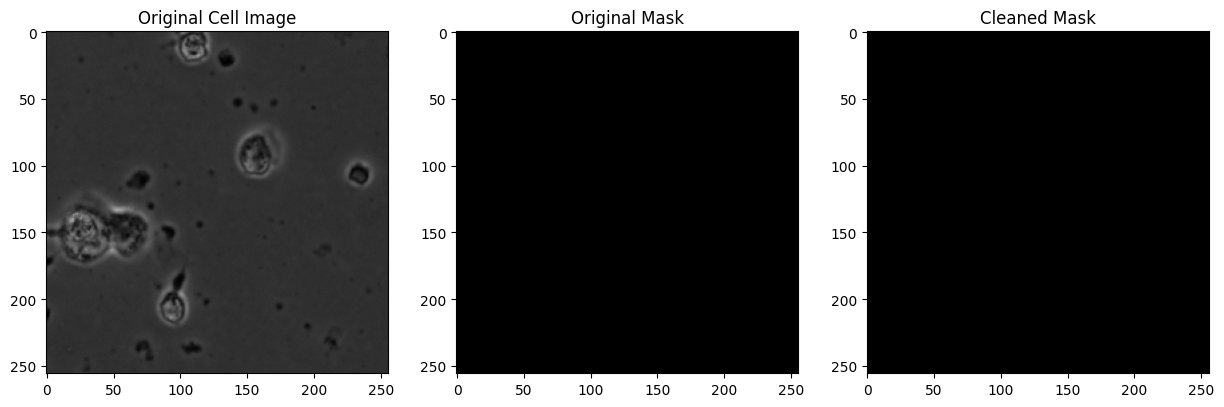

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original cell image and predicted mask
cell_image = image
mask = predict_test_binary[0]

# Apply morphological operations
kernel = np.ones((3, 3), np.uint8)

# Opening to remove small objects
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Save the sure background as the cleaned mask
# cv2.imwrite('/mnt/data/cleaned_mask.png', sure_bg)

# Display the original cell image, original mask, and cleaned mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Cell Image')
plt.imshow(cell_image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Cleaned Mask')
plt.imshow(sure_bg, cmap='gray')

plt.show()


In [11]:
cv2.imshow("Segmentation Result", predict_test[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
import cv2
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="UNET/saved_models/quantize_models/thp1_dataset_v3_15_epochs.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and prepare input image
input_image = cv2.imread(test_x[15])
input_image = cv2.resize(input_image, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
input_image = input_image.astype(np.float32) / 255.0

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], [input_image])

# Run inference
interpreter.invoke()

# Get segmentation result
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process segmentation result (if needed)
segmentation_result = output_data[0]

# Display or save the segmentation result
# For example:
# cv2.imshow("Segmentation Result", segmentation_result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [15]:

cv2.imshow("Segmentation Result", segmentation_result)
cv2.waitKey(0)
cv2.destroyAllWindows()

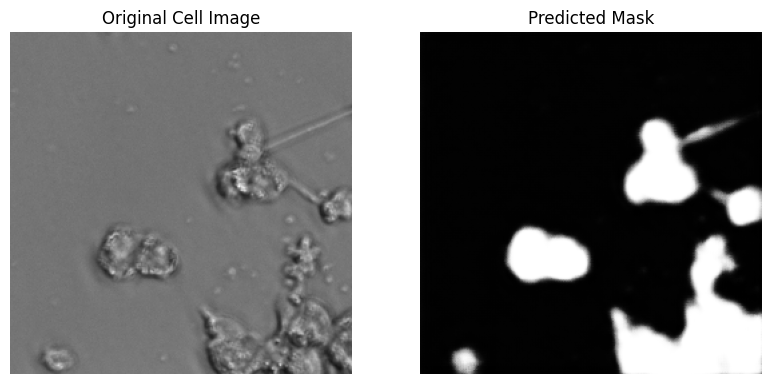

In [17]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Cell Image')
plt.imshow(input_image)
plt.axis('off')  # Hide axes

plt.subplot(1, 3, 2)
plt.title('Predicted Mask')
plt.imshow(segmentation_result, cmap='gray')

plt.axis('off')  # Hide axes
plt.show()


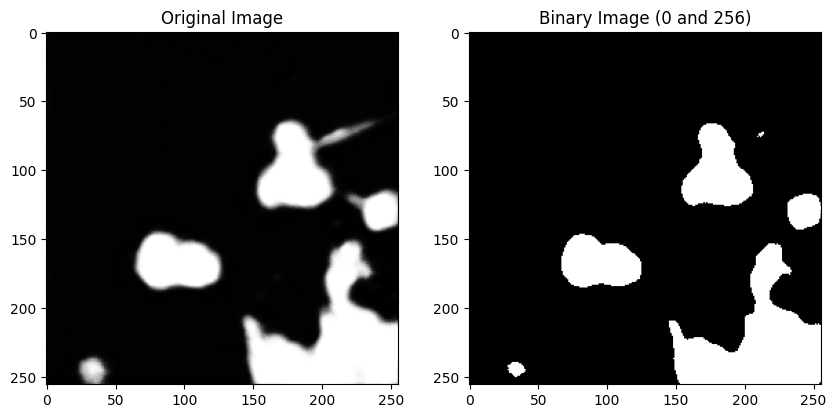

In [28]:

def convert_to_0_and_256(image_path):
    # Load the image
    image = image_path
    
    # Convert the image to binary (0 and 256)
    _, binary_image = cv2.threshold(image, 0.8, 256, cv2.THRESH_BINARY)
    

    
    # Display the original and binary images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Binary Image (0 and 256)')
    plt.imshow(binary_image, cmap='gray')
    plt.show()
    return binary_image



# Convert the image
binary_image = convert_to_0_and_256(segmentation_result)


In [51]:
print(binary_image)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


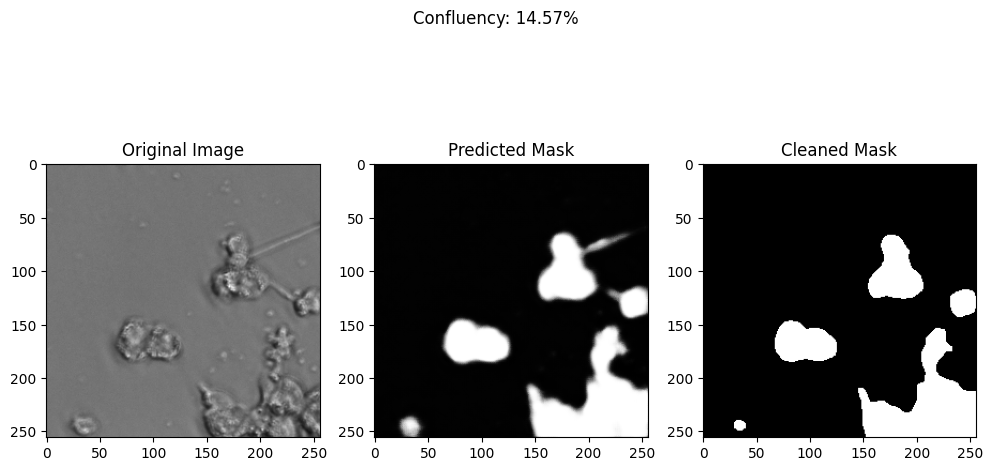

Confluency: 14.57%


In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_confluency(image_path, mask_path):
    # Load the original image and the predicted mask
    mask = mask_path
    
     # Convert the image to binary (0 and 256)
    _, binary_image = cv2.threshold(mask, 0.8, 256, cv2.THRESH_BINARY)
   
    
    # Apply morphological operations to clean the mask
    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)
    
    # Calculate the total number of pixels
    total_pixels = cleaned_mask.size
    
    # Calculate the number of white pixels (cell coverage)
    cell_pixels = cv2.countNonZero(cleaned_mask)
    
    # Calculate confluency
    confluency = (cell_pixels / total_pixels) * 100

    # Display the images and results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_path, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Cleaned Mask")
    plt.imshow(cleaned_mask, cmap='gray')

    plt.suptitle(f"Confluency: {confluency:.2f}%")
    plt.show()

    return confluency,cleaned_mask

# Example usage
image_path = input_image
mask_path = segmentation_result
confluency,cleaned_mask = calculate_confluency(image_path, mask_path)
print(f"Confluency: {confluency:.2f}%")


In [44]:
from PIL import Image
import numpy as np

def count_white_pixels(image):

    white_pixel_count = np.sum(image == 256)
    return white_pixel_count


def calculate_cell_area_cm2(white_pixel_count, pixel_area_um2):
    # Convert pixel area from µm² to cm²
    pixel_area_cm2 = pixel_area_um2 * 1e-8  # 1 µm² = 1e-8 cm²
    return white_pixel_count * pixel_area_cm2

def calculate_cell_area_mm2(white_pixel_count, pixel_area_um2):
    # Convert pixel area from µm² to cm²
    pixel_area_mm2 = pixel_area_um2 * 1e-6  # 1 µm² = 1e-6 mm²
    return white_pixel_count * pixel_area_mm2

# Example usage
white_pixel_count = count_white_pixels(cleaned_mask)

# Assume each pixel represents an area of 1 µm² (replace with actual pixel area if different)
pixel_area_um2 = 50

cell_area_cm2 = calculate_cell_area_cm2(white_pixel_count, pixel_area_um2)
cell_area_mm2 = calculate_cell_area_mm2(white_pixel_count, pixel_area_um2)

print(f'Number of white pixels: {white_pixel_count}')
print(f'Area of the cells: {cell_area_cm2} cm2')
print(f'Area of the cells: {cell_area_mm2} mm2')


Number of white pixels: 9551
Area of the cells: 0.004775499999999999 cm2
Area of the cells: 0.47755 mm2


In [69]:
from PIL import Image
import os

def crop_image_to_256x256(image_path, output_folder):
    image = Image.open(image_path)
    img_width, img_height = image.size

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    crop_width, crop_height = 256, 256
    for i in range(0, img_width, crop_width):
        for j in range(0, img_height, crop_height):
            box = (i, j, i + crop_width, j + crop_height)
            cropped_image = image.crop(box)
            cropped_image.save(os.path.join(output_folder, f'cropped_{i}_{j}.png'))

image_path = "UNET/our_dataset/test_images/D2_THP1d_cells_001.tif"
output_folder = "UNET/our_dataset/output_test_images/test_1_D2_THP1d_cells_001"
crop_image_to_256x256(image_path, output_folder)


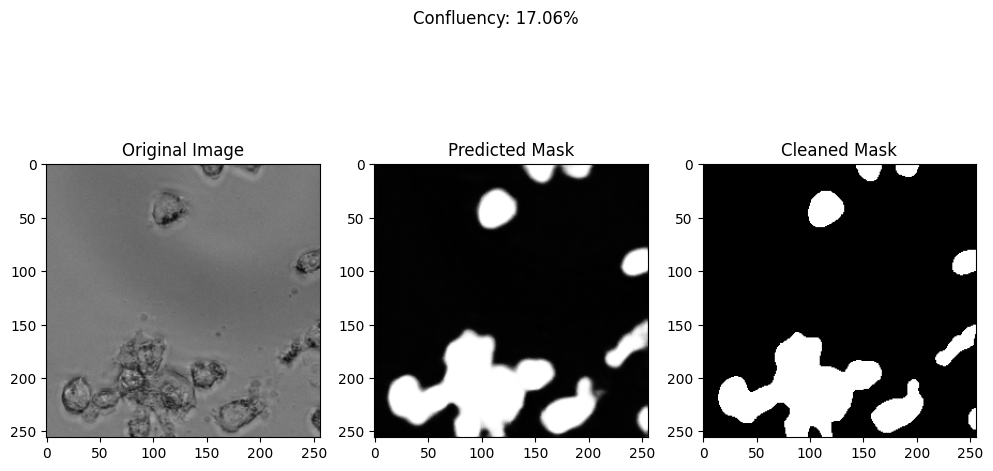

Number of white pixels: 11180
Area of the cells: 0.0055899999999999995 cm2
Area of the cells: 0.5589999999999999 mm2
confluency 1 is 17.059326171875


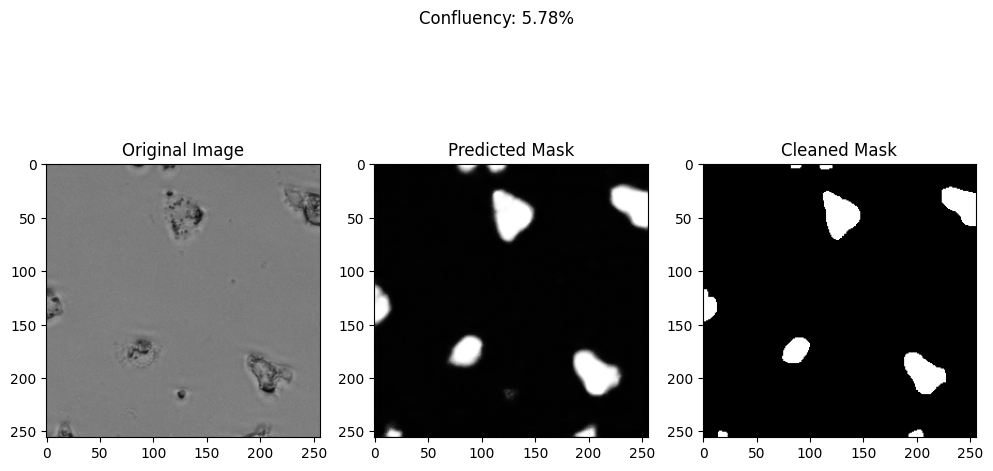

Number of white pixels: 3785
Area of the cells: 0.0018924999999999999 cm2
Area of the cells: 0.18924999999999997 mm2
confluency 2 is 5.77545166015625


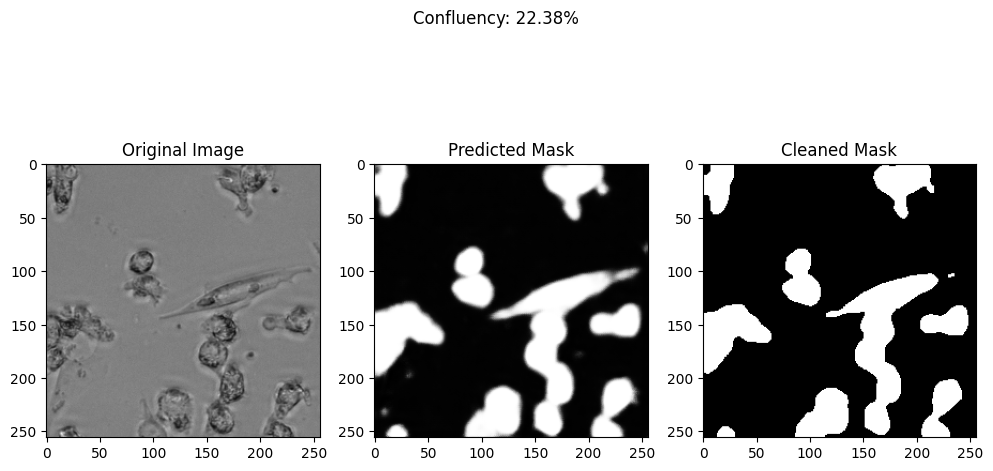

Number of white pixels: 14670
Area of the cells: 0.0073349999999999995 cm2
Area of the cells: 0.7334999999999999 mm2
confluency 3 is 22.3846435546875


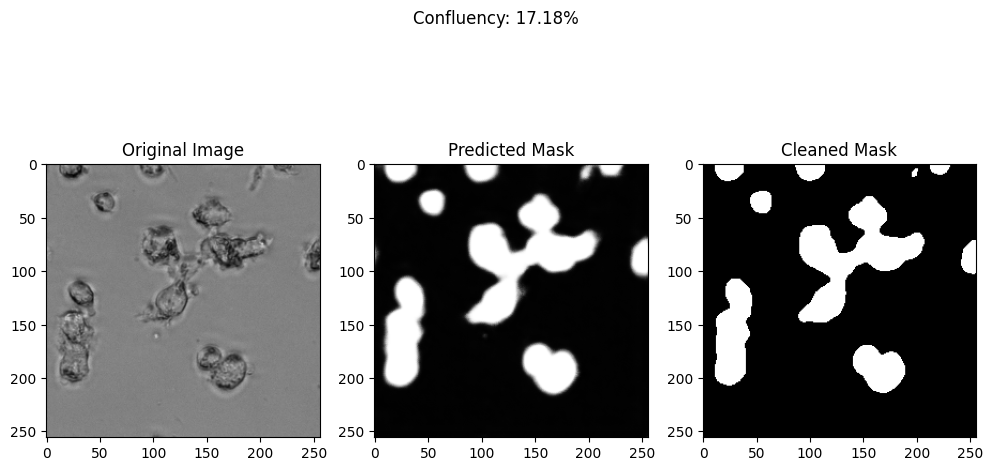

Number of white pixels: 11259
Area of the cells: 0.0056295 cm2
Area of the cells: 0.56295 mm2
confluency 4 is 17.17987060546875


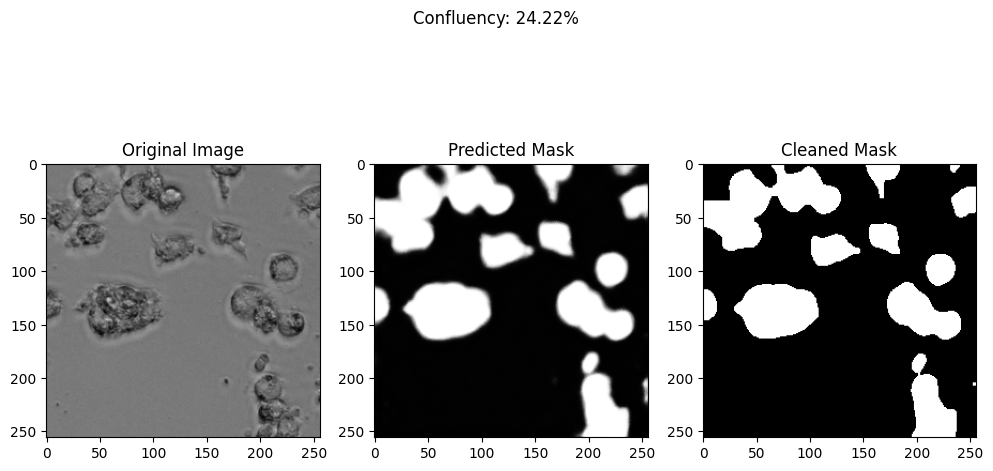

Number of white pixels: 15875
Area of the cells: 0.0079375 cm2
Area of the cells: 0.79375 mm2
confluency 5 is 24.22332763671875


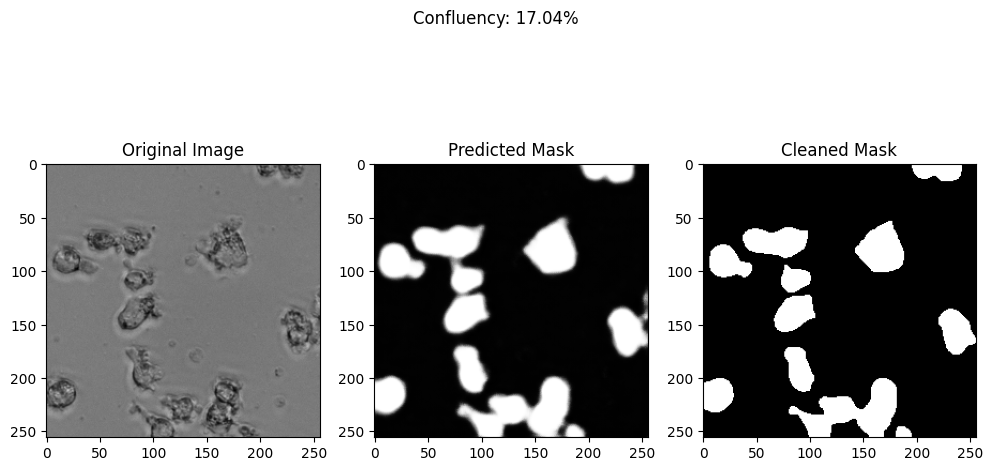

Number of white pixels: 11169
Area of the cells: 0.0055845 cm2
Area of the cells: 0.55845 mm2
confluency 6 is 17.04254150390625


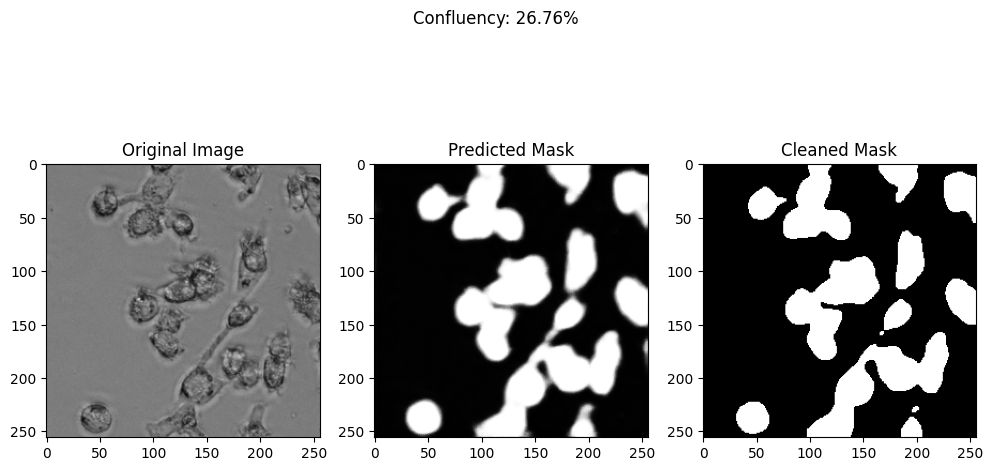

Number of white pixels: 17535
Area of the cells: 0.0087675 cm2
Area of the cells: 0.8767499999999999 mm2
confluency 7 is 26.75628662109375


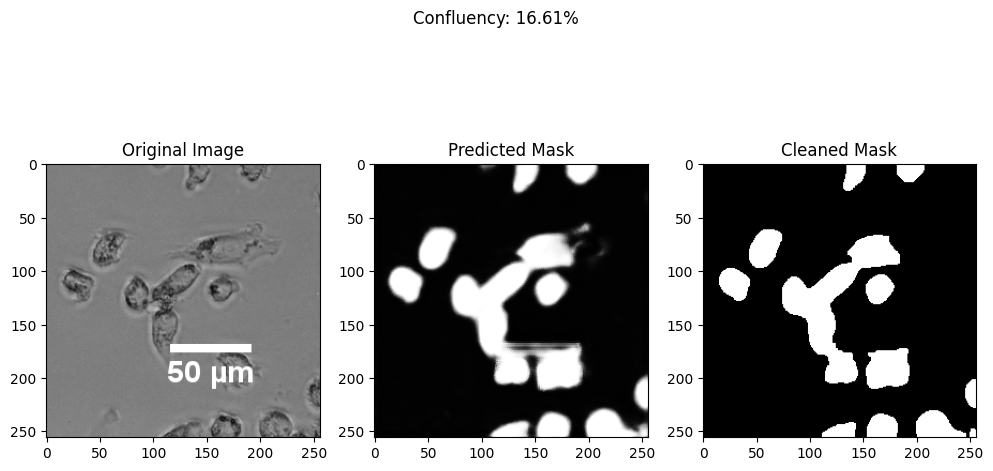

Number of white pixels: 10887
Area of the cells: 0.0054434999999999996 cm2
Area of the cells: 0.54435 mm2
confluency 8 is 16.61224365234375


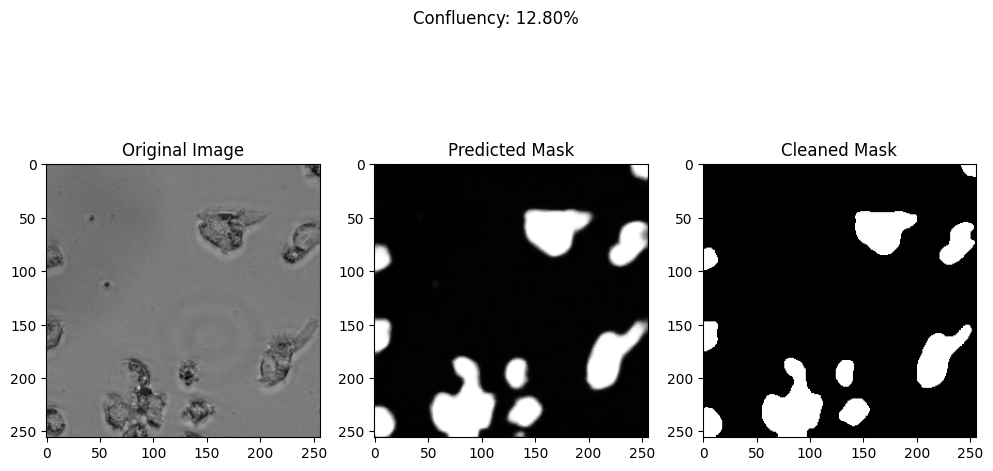

Number of white pixels: 8386
Area of the cells: 0.004193 cm2
Area of the cells: 0.41929999999999995 mm2
confluency 9 is 12.7960205078125


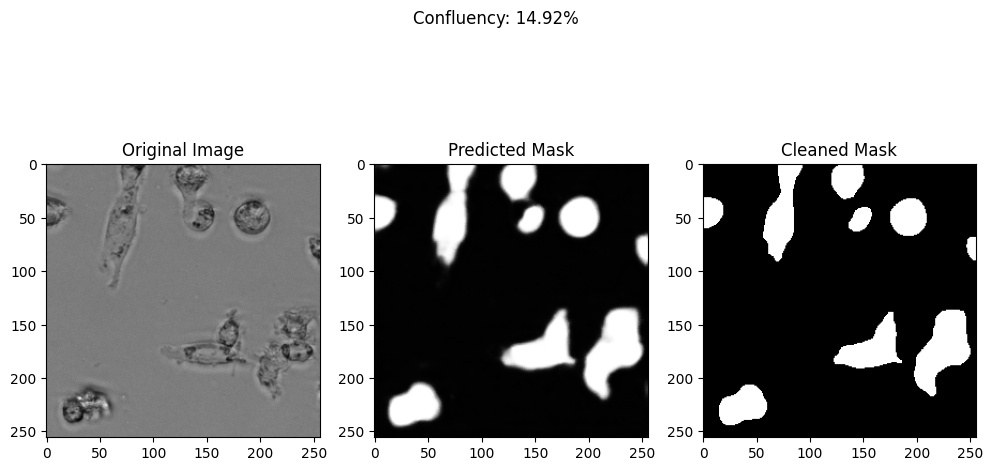

Number of white pixels: 9775
Area of the cells: 0.0048874999999999995 cm2
Area of the cells: 0.48874999999999996 mm2
confluency 10 is 14.91546630859375


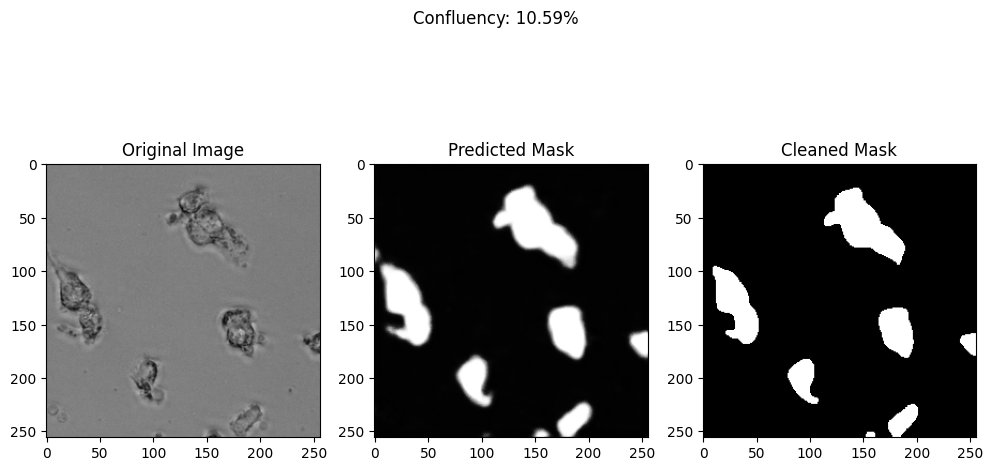

Number of white pixels: 6943
Area of the cells: 0.0034714999999999998 cm2
Area of the cells: 0.34714999999999996 mm2
confluency 11 is 10.59417724609375


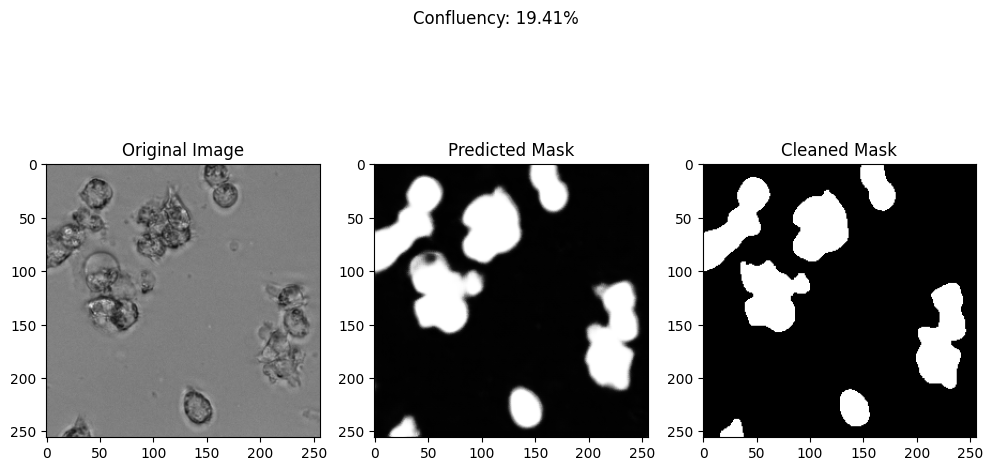

Number of white pixels: 12723
Area of the cells: 0.0063615 cm2
Area of the cells: 0.63615 mm2
confluency 12 is 19.41375732421875


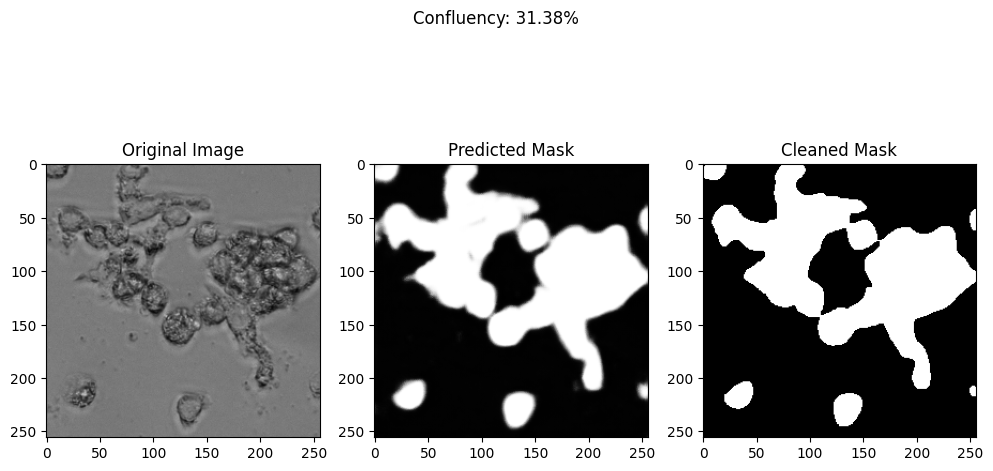

Number of white pixels: 20564
Area of the cells: 0.010282 cm2
Area of the cells: 1.0282 mm2
confluency 13 is 31.378173828125


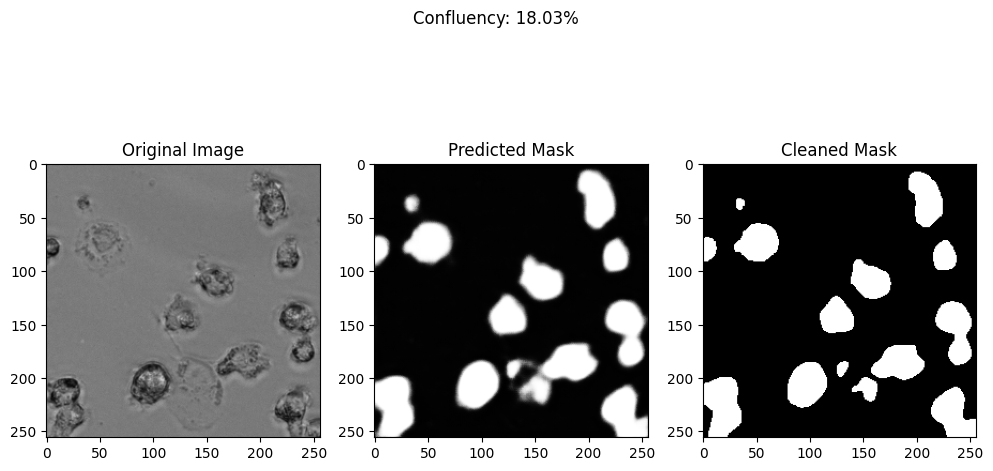

Number of white pixels: 11814
Area of the cells: 0.005907 cm2
Area of the cells: 0.5907 mm2
confluency 14 is 18.0267333984375


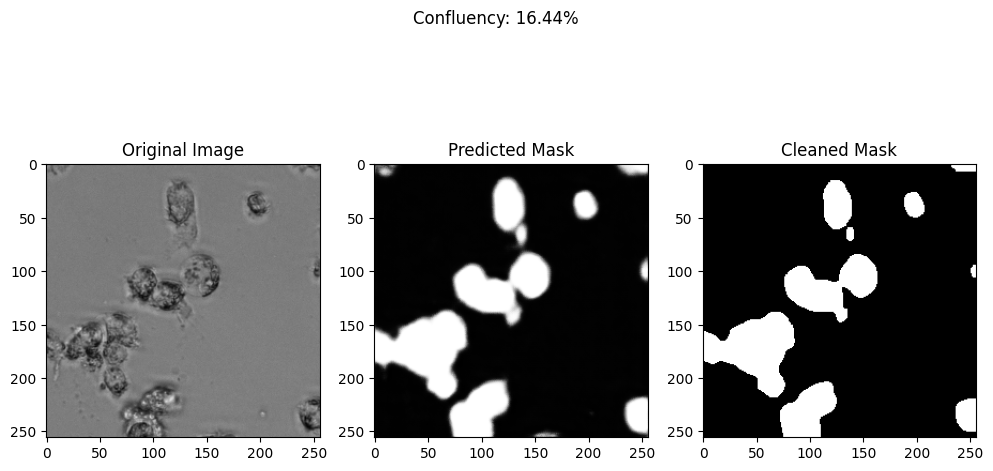

Number of white pixels: 10777
Area of the cells: 0.0053885 cm2
Area of the cells: 0.5388499999999999 mm2
confluency 15 is 16.44439697265625


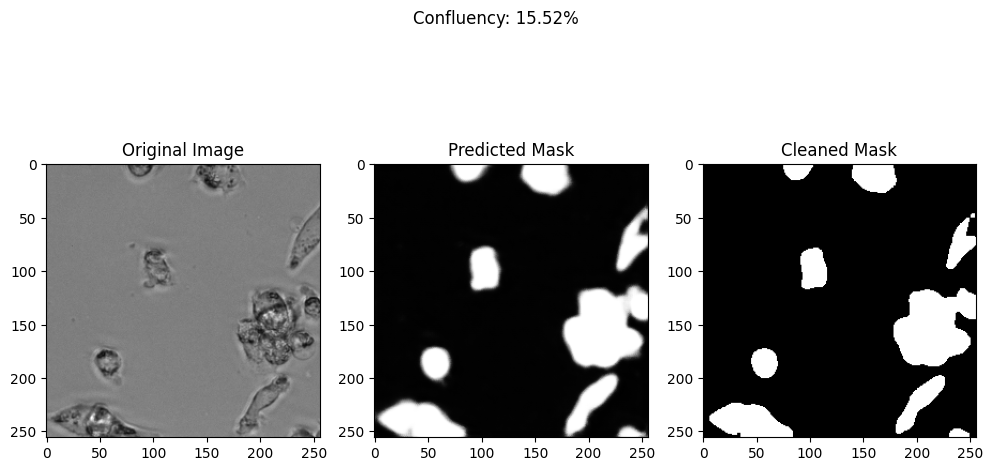

Number of white pixels: 10170
Area of the cells: 0.005085 cm2
Area of the cells: 0.5085 mm2
confluency 16 is 15.5181884765625


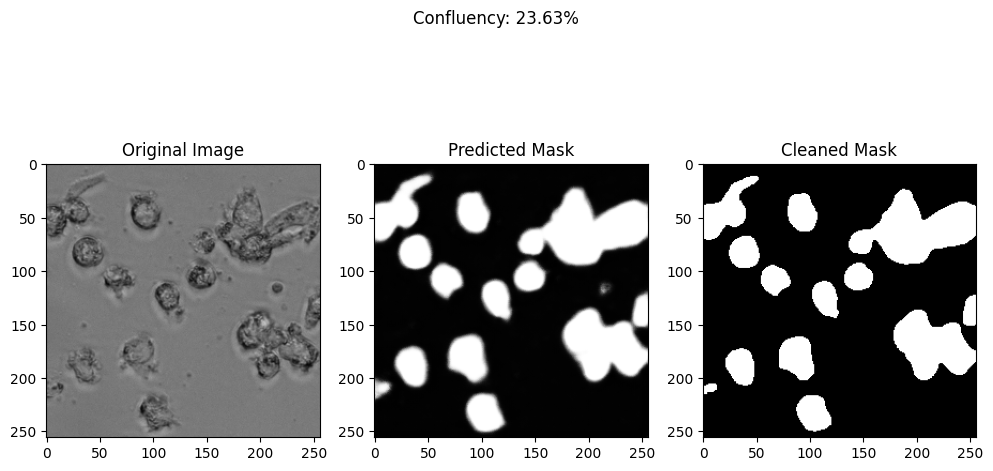

Number of white pixels: 15488
Area of the cells: 0.007744 cm2
Area of the cells: 0.7744 mm2
confluency 17 is 23.6328125


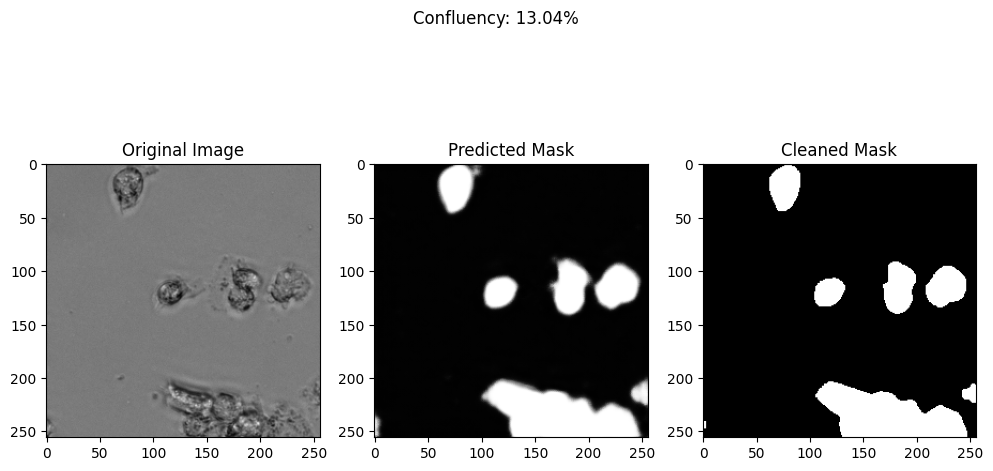

Number of white pixels: 8544
Area of the cells: 0.004272 cm2
Area of the cells: 0.42719999999999997 mm2
confluency 18 is 13.037109375


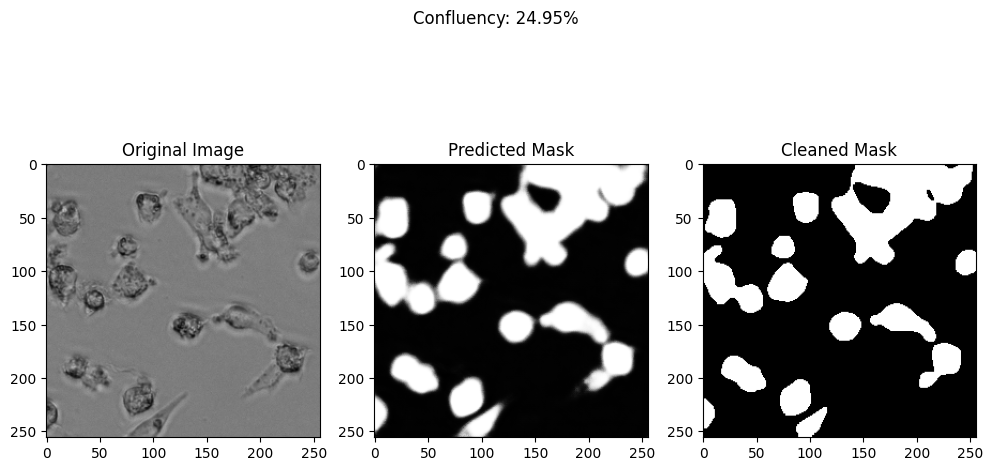

Number of white pixels: 16354
Area of the cells: 0.008177 cm2
Area of the cells: 0.8177 mm2
confluency 19 is 24.9542236328125


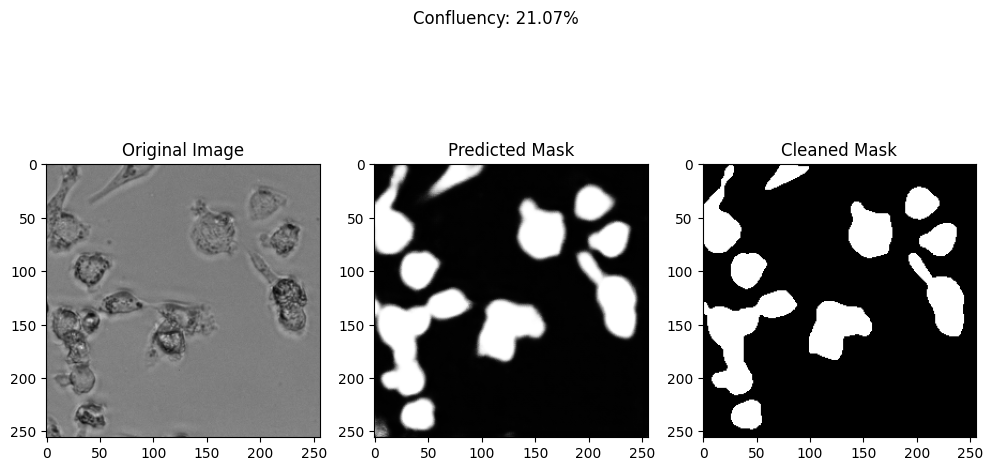

Number of white pixels: 13811
Area of the cells: 0.006905499999999999 cm2
Area of the cells: 0.6905499999999999 mm2
confluency 20 is 21.07391357421875
overall confluency sum:  368.81866455078125
overall confluency 18.440933227539062


In [71]:
import os
from PIL import Image

def process_image(image):
    # prdict image
    predicted_mask = predict(image)
    confluency, cleaned_mask = calculate_confluency(image,predicted_mask)
    white_pixel_count = count_white_pixels(cleaned_mask)
    
    # Assume each pixel represents an area of 1 µm² (replace with actual pixel area if different)
    pixel_area_um2 = 50

    cell_area_cm2 = calculate_cell_area_cm2(white_pixel_count, pixel_area_um2)
    cell_area_mm2 = calculate_cell_area_mm2(white_pixel_count, pixel_area_um2)

    print(f'Number of white pixels: {white_pixel_count}')
    print(f'Area of the cells: {cell_area_cm2} cm2')
    print(f'Area of the cells: {cell_area_mm2} mm2')
    
    
    
    return cleaned_mask,confluency, cell_area_mm2
   

def read_and_process_images(input_folder):
    images = []
    masks = []
    overall_confluency = 0
    n=0
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            
            image_path = os.path.join(input_folder, filename)

            image = cv2.imread(image_path)
            image_array = np.asarray(image)
            images.append(image_array)
            cleaned_mask,confluency, cell_area_mm2 = process_image(image_array)
            save_mask(cleaned_mask,n)
            
            masks.append(cleaned_mask)
            
            
            n=n+1
            print(f'confluency {n} is {confluency}')
            overall_confluency = overall_confluency + confluency
            
    
    print("overall confluency sum: ", overall_confluency)
    print("overall confluency", overall_confluency/n)


input_folder = "UNET/our_dataset/output_test_images/test_1_D2_THP1d_cells_001"
read_and_process_images(input_folder)


In [70]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def save_mask(mask,n):
    image = Image.fromarray(mask).convert('L')
    image.save(f'UNET/our_dataset/output_test_images/test_1_D2_THP1d_cells_001_masks/mask_{n}.png')

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="UNET/saved_models/quantize_models/thp1_dataset_v3_15_epochs.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape details
input_height = input_details[0]['shape'][1]
input_width = input_details[0]['shape'][2]

def preprocess_image(image):
    input_image = cv2.resize(image, (input_width, input_height))
    input_image = input_image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    return input_image

def predict(image):
    # Preprocess the image
    input_image = preprocess_image(image)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get segmentation result
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Display the original and binary images
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.title('Original Image')
    # plt.imshow(image, cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.title('Segmentation Result')
    # plt.imshow(output_data[0], cmap='gray')
    # plt.show()

    return output_data[0]

# Example usage:
# image = cv2.imread('path_to_your_image.jpg', cv2.IMREAD_GRAYSCALE)
# result = predict(image)
